<a href="https://colab.research.google.com/github/rajprasad001/deep_learning_concepts/blob/master/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
def data_split(label, instance):
  ips = [] # instance_primary_subset = ips
  lps = [] # label_primary_subset = lps
  iss = [] # instance_secondary_subset = iss
  lss = [] # label_secondary_subset = lss
  ind = []
  for idx,item in enumerate(label):
    if item == 1 or item == 2 or item == 0:
      lss.append(label[idx])
      iss.append(instance[idx])
      ind.append(idx)
  for idx,item in enumerate(label):
    if idx not in ind:
      lps.append(label[idx])
      ips.append(instance[idx])
  ips = np.asarray(ips)
  lps = np.asarray(lps)
  iss = np.asarray(iss)
  lss = np.asarray(lss)
  return (ips,lps,iss,lss)

In [7]:
x_train_prim,y_train_prim, x_train_sec,y_train_sec =  data_split(Y_train,X_train)
x_test_prim,y_test_prim,x_test_sec,y_test_sec = data_split(Y_test,X_test)

In [8]:
print('x_train_prim :{}'.format(x_train_prim.shape))
print('y_train_prim :{}'.format(y_train_prim.shape))
print('x_train_sec  :{}'.format(x_train_sec.shape))
print('Y_train_sec  :{}'.format(y_train_sec.shape))
print('x_test_prim  :{}'.format(x_test_prim.shape))
print('y_test_prim  :{}'.format(y_test_prim.shape))
print('x_test_sec   :{}'.format(x_test_sec.shape))
print('Y_test_sec   :{}'.format(y_test_sec.shape))


x_train_prim :(41377, 28, 28)
y_train_prim :(41377,)
x_train_sec  :(18623, 28, 28)
Y_train_sec  :(18623,)
x_test_prim  :(6853, 28, 28)
y_test_prim  :(6853,)
x_test_sec   :(3147, 28, 28)
Y_test_sec   :(3147,)


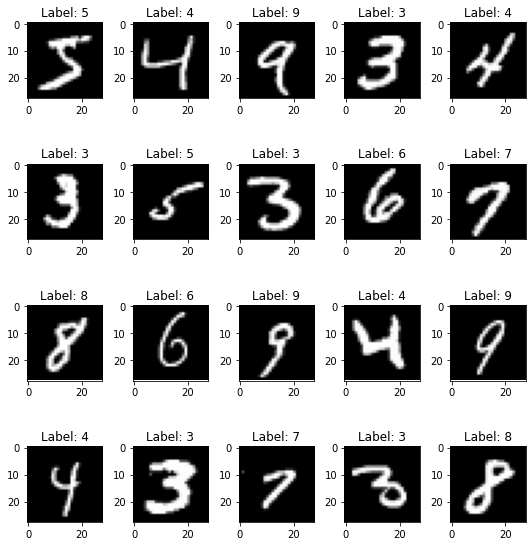

In [6]:
num = 20
images = x_train_prim[:num]
labels = y_train_prim[:num]

num_row = 4
num_col = 5
# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
for i in range(num):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(images[i], cmap='gray')
    ax.set_title('Label: {}'.format(labels[i]))
plt.tight_layout()
plt.show()